In [ ]:
# Установка необходимых библиотек
!pip install datasets sentence-transformers torch transformers

from datasets import load_dataset
from sentence_transformers import SentenceTransformer, losses, InputExample
from torch.utils.data import DataLoader
import torch

In [ ]:
# 1. Загрузка датасета MIRACL для русского языка
lang = 'ru'
dataset = load_dataset('miracl/miracl', lang)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.56k [00:00<?, ?B/s]

miracl.py:   0%|          | 0.00/6.49k [00:00<?, ?B/s]

The repository for miracl/miracl contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/miracl/miracl.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


topics.miracl-v1.0-ru-dev.tsv:   0%|          | 0.00/109k [00:00<?, ?B/s]

qrels.miracl-v1.0-ru-dev.tsv:   0%|          | 0.00/256k [00:00<?, ?B/s]

topics.miracl-v1.0-ru-test-b.tsv:   0%|          | 0.00/53.6k [00:00<?, ?B/s]

topics.miracl-v1.0-ru-train.tsv:   0%|          | 0.00/406k [00:00<?, ?B/s]

qrels.miracl-v1.0-ru-train.tsv:   0%|          | 0.00/663k [00:00<?, ?B/s]

topics.miracl-v1.0-ru-test-a.tsv:   0%|          | 0.00/83.2k [00:00<?, ?B/s]

Generating dev split: 0 examples [00:00, ? examples/s]

README.md:   0%|          | 0.00/6.85k [00:00<?, ?B/s]

miracl-corpus.py:   0%|          | 0.00/3.15k [00:00<?, ?B/s]

docs-0.jsonl.gz:   0%|          | 0.00/100M [00:00<?, ?B/s]

docs-1.jsonl.gz:   0%|          | 0.00/98.0M [00:00<?, ?B/s]

docs-2.jsonl.gz:   0%|          | 0.00/90.1M [00:00<?, ?B/s]

docs-3.jsonl.gz:   0%|          | 0.00/89.4M [00:00<?, ?B/s]

docs-4.jsonl.gz:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

docs-5.jsonl.gz:   0%|          | 0.00/88.5M [00:00<?, ?B/s]

docs-6.jsonl.gz:   0%|          | 0.00/81.1M [00:00<?, ?B/s]

docs-7.jsonl.gz:   0%|          | 0.00/80.2M [00:00<?, ?B/s]

docs-8.jsonl.gz:   0%|          | 0.00/74.5M [00:00<?, ?B/s]

docs-9.jsonl.gz:   0%|          | 0.00/73.5M [00:00<?, ?B/s]

docs-10.jsonl.gz:   0%|          | 0.00/75.7M [00:00<?, ?B/s]

docs-11.jsonl.gz:   0%|          | 0.00/78.3M [00:00<?, ?B/s]

docs-12.jsonl.gz:   0%|          | 0.00/76.5M [00:00<?, ?B/s]

docs-13.jsonl.gz:   0%|          | 0.00/78.2M [00:00<?, ?B/s]

docs-14.jsonl.gz:   0%|          | 0.00/78.3M [00:00<?, ?B/s]

docs-15.jsonl.gz:   0%|          | 0.00/79.4M [00:00<?, ?B/s]

docs-16.jsonl.gz:   0%|          | 0.00/81.4M [00:00<?, ?B/s]

docs-17.jsonl.gz:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

docs-18.jsonl.gz:   0%|          | 0.00/81.0M [00:00<?, ?B/s]

docs-19.jsonl.gz:   0%|          | 0.00/6.75M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating testB split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating testA split: 0 examples [00:00, ? examples/s]

In [ ]:
# 2. Для повышения качества данных для обучения будем использовать аугментацию

# Настройка модели для аугментации (ruT5)

from transformers import T5ForConditionalGeneration, T5Tokenizer

aug_model_name = "cointegrated/rut5-base-paraphraser"
aug_tokenizer = T5Tokenizer.from_pretrained(aug_model_name)
aug_model = T5ForConditionalGeneration.from_pretrained(aug_model_name)

# Перенос модели на GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
aug_model.to(device)

# Функция для перефразирования запросов
def paraphrase(text, max_length=128, num_beams=5):
    input_text = f"переформулировать: {text}"
    inputs = aug_tokenizer(input_text, return_tensors="pt", max_length=max_length, truncation=True)
    inputs = inputs.to(device)

    outputs = aug_model.generate(
        **inputs,
        max_length=max_length,
        num_beams=num_beams,
        early_stopping=True,
        no_repeat_ngram_size=2
    )

    paraphrased_text = aug_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return paraphrased_text

# Батчевая версия для ускорения
def batch_paraphrase(texts, batch_size=16, max_length=128, num_beams=5):
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = aug_tokenizer([f"переформулировать: {t}" for t in batch],
                              return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        inputs = inputs.to(device)
        outputs = aug_model.generate(
            **inputs,
            max_length=max_length,
            num_beams=num_beams,
            early_stopping=True,
            no_repeat_ngram_size=2
        )
        results.extend([aug_tokenizer.decode(out, skip_special_tokens=True) for out in outputs])
    return results

tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/828k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

In [ ]:
# 3. Подготовка данных для обучения с аугментацией
train_examples = []

def create_input_examples(split_name, examples_list):
    split_dataset = dataset[split_name]

    # Преобразуем данные в список для удобства
    queries = [example['query'] for example in split_dataset]
    positive_passages = [example['positive_passages'] for example in split_dataset]
    negative_passages = [example['negative_passages'] for example in split_dataset]

    # Генерируем перефразированные запросы
    print("Генерация перефразированных запросов...")
    paraphrased_queries = batch_paraphrase(queries, batch_size=16)

    # Добавляем исходные примеры
    for query, pos_passages, neg_passages in zip(queries, positive_passages, negative_passages):
        if not pos_passages:  # Пропускаем, если нет позитивных пассажей
            continue
        for pos in pos_passages:
            examples_list.append(InputExample(texts=[query, pos['text']]))

    # Добавляем аугментированные примеры
    for paraphrased_query, pos_passages, neg_passages in zip(paraphrased_queries, positive_passages, negative_passages):
        if not pos_passages:
            continue
        for pos in pos_passages:
            examples_list.append(InputExample(texts=[paraphrased_query, pos['text']]))

In [ ]:
# Создаём тренировочные примеры
create_input_examples("train", train_examples)
print(f"Всего примеров после аугментации: {len(train_examples)}")

Генерация перефразированных запросов...
Всего примеров после аугментации: 20000


In [ ]:
# 4. Создание DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)

In [ ]:
# 5. Загрузка модели
# Используем многоязычную модель, которая поддерживает русский язык
model = SentenceTransformer('distilbert-base-multilingual-cased')

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
# 6. Определение функции потерь
# MultipleNegativesRankingLoss использует только позитивные пары,
# негативные примеры берутся из других элементов батча
train_loss = losses.MultipleNegativesRankingLoss(model)

In [ ]:
# 7. Настройка параметров обучения
num_epochs = 10
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% от всех шагов

In [ ]:
# 8. Обучение модели
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    optimizer_params={'lr': 2e-5},  # Скорость обучения
    scheduler='WarmupLinear',       # Линейный прогрев скорости обучения
    save_best_model=True,
    output_path='miracl_qa_model_ru',  # Куда сохранить модель
    show_progress_bar=True
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sadinat22 (sadinat22-google) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.558000
1000,0.071800
1500,0.040800
2000,0.028500
2500,0.025300
3000,0.018300
3500,0.021800
4000,0.014300
4500,0.017400
5000,0.016100


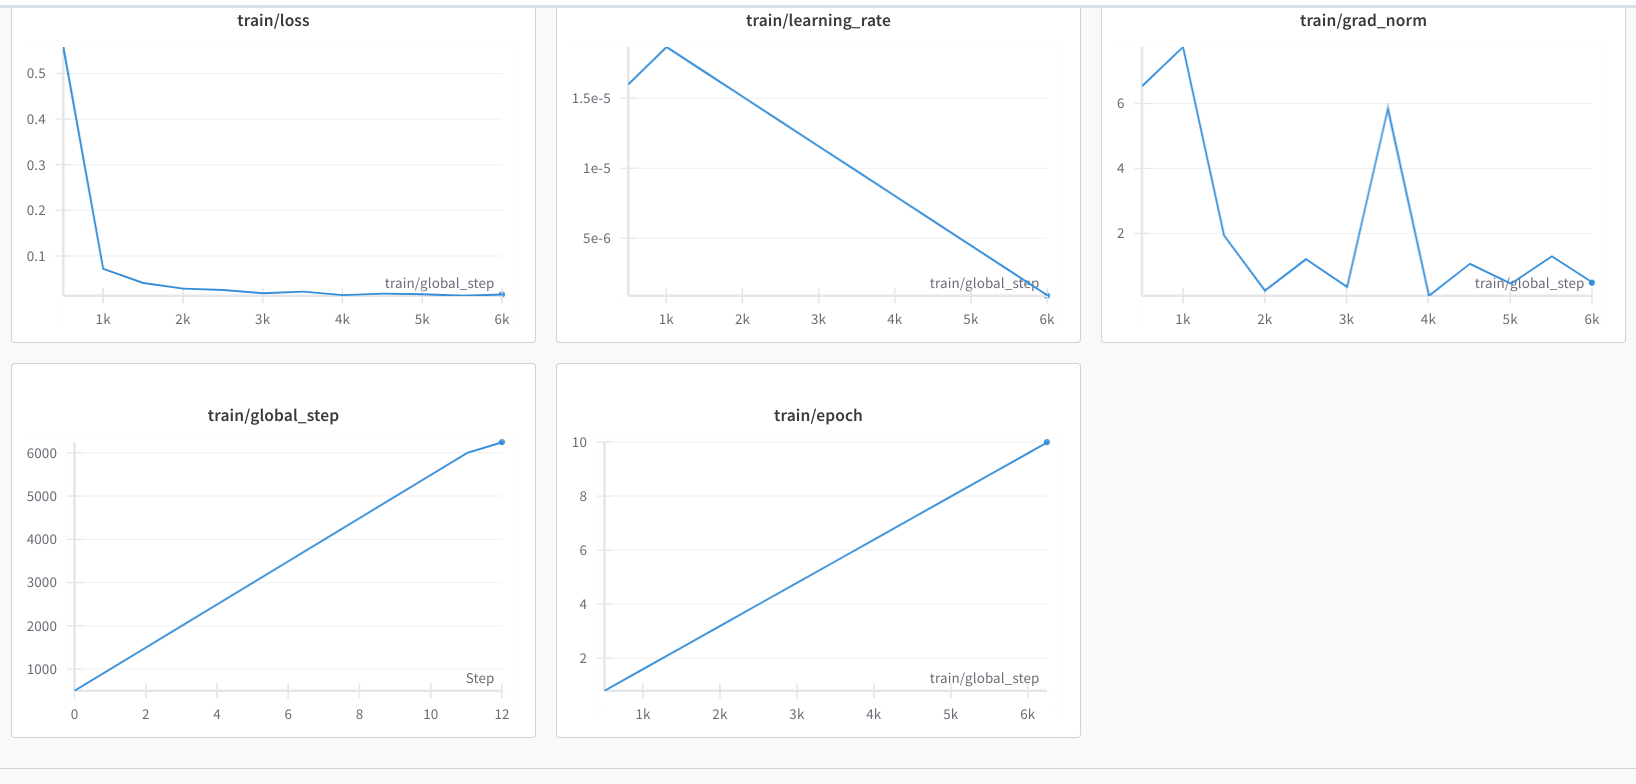

In [ ]:
# 9. Сохранение модели (уже выполняется в model.fit через output_path)
print("Модель обучена и сохранена в 'miracl_qa_model_ru'")

Модель обучена и сохранена в 'miracl_qa_model_ru'


In [ ]:
!zip -r /content/miracl_qa_model_ru-distilbert-base-multilingual-cased.zip /content/miracl_qa_model_ru

In [ ]:
# 10. Инференс (пример использования обученной модели)

# Извлечение всех пассажей из тренировочного набора
all_passages = []
for example in dataset['train']:
    for pos in example['positive_passages']:
        all_passages.append(pos['text'])
    for neg in example['negative_passages']:
        all_passages.append(neg['text'])

for example in dataset['dev']:
    for pos in example['positive_passages']:
        all_passages.append(pos['text'])
    for neg in example['negative_passages']:
        all_passages.append(neg['text'])

for example in dataset['testA']:
    for pos in example['positive_passages']:
        all_passages.append(pos['text'])
    for neg in example['negative_passages']:
        all_passages.append(neg['text'])

for example in dataset['testB']:
    for pos in example['positive_passages']:
        all_passages.append(pos['text'])
    for neg in example['negative_passages']:
        all_passages.append(neg['text'])

print(f"Всего пассажей в базе знаний: {len(all_passages)}")

Всего пассажей в базе знаний: 47021


In [ ]:
!pip install faiss-cpu  # Установка FAISS

import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

# Загружаем предварительно обученную иодель, ранее сохраненную на Гугл диск
import gdown
url = 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1wh-RtsoNmxXVcqf2bEieDmVYRvLE17cj'
gdown.download(url, '/content/')

!unzip -q /content/miracl_qa_model_ru-distilbert-base-multilingual-cased.zip -d /content/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 71.3 MB/s eta 0:00:00


Downloading...
From: https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1wh-RtsoNmxXVcqf2bEieDmVYRvLE17cj
To: /content/miracl_qa_model_ru-distilbert-base-multilingual-cased.zip
100%|██████████| 501M/501M [00:09<00:00, 53.3MB/s]


In [ ]:
# Загрузка модели
model = SentenceTransformer('/content/content/miracl_qa_model_ru')

# Преобразование пассажей в эмбеддинги
passage_embeddings = model.encode(all_passages, convert_to_tensor=False, show_progress_bar=True)

# Нормализация эмбеддингов для косинусного сходства
passage_embeddings = passage_embeddings / np.linalg.norm(passage_embeddings, axis=1)[:, np.newaxis]

# Создание FAISS индекса с Inner Product (косинусное сходство)
dimension = passage_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner Product вместо L2
index.add(passage_embeddings)

# Сохранение индекса и пассажей
faiss.write_index(index, "passage_index.faiss")
np.save("passages.npy", all_passages)

Batches:   0%|          | 0/1470 [00:00<?, ?it/s]

In [ ]:
def answer_question(query, model, index, passages, top_k=1):
    # Преобразование запроса в эмбеддинг
    query_embedding = model.encode(query, convert_to_tensor=False)

    # Нормализация запроса
    query_embedding = query_embedding / np.linalg.norm(query_embedding)

    # Поиск top_k ближайших пассажей
    scores, indices = index.search(np.array([query_embedding]), top_k)

    # Извлечение результатов
    best_passage = passages[indices[0][0]]
    best_score = scores[0][0]  # Score — это косинусное сходство

    return best_passage, best_score

In [ ]:
# Тестовый пример 1
test_query = "Когда родилась Князева Марина Леонидовна?"
best_answer, score = answer_question(test_query, model, index, all_passages)
print(f"Запрос: {test_query}")
print(f"Ответ: {best_answer}")
print(f"Score: {score:.4f}")

Запрос: Когда родилась Князева Марина Леонидовна?
Ответ: Князева Марина Леонидовна (род. 7 мая 1952 г.) — поэт, культуролог, художник-график, детский писатель, старший научный сотрудник кафедры периодической печати факультета журналистики МГУ имени М. В. Ломоносова, кандидат филологических наук.
Score: 0.8424


In [ ]:
# Тестовый пример 2
test_query = "Когда был спущен на воду первый миноносец Спокойный?"
best_answer, score = answer_question(test_query, model, index, all_passages)
print(f"Запрос: {test_query}")
print(f"Ответ: {best_answer}")
print(f"Score: {score:.4f}")

Запрос: Когда был спущен на воду первый миноносец Спокойный?
Ответ: Эскадренный миноносец заложен в 1900 году на Невском заводе в Санкт-Петербурге под названием «Перепел». 27 февраля 1902 года начат сборкой, и 4 мая 1903 года спущен на воду в Порт-Артуре. Принят в казну в декабре 1903 года. С 9 марта 1902 года — «Скорый».
К началу русско-японской войны «Скорый» входил в состав 2-го отряда миноносцев 1-й Тихоокеанской эскадры. В задачи миноносца входило: дозорная и разведывательная служба, траление и постановка мины у побережья Порт-Артура.
Score: 0.7265


In [ ]:
# Тестовый пример 3
test_query = "Как долго существовало британское телевизионное игровое шоу Хрустальный лабиринт?"
best_answer, score = answer_question(test_query, model, index, all_passages)
print(f"Запрос: {test_query}")
print(f"Ответ: {best_answer}")
print(f"Score: {score:.4f}")

Запрос: Как долго существовало британское телевизионное игровое шоу Хрустальный лабиринт?
Ответ: Хрустальный лабиринт был одним из самых серьезных и коммерчески успешных британских телевизионных игровых шоу. Значительная часть этого успеха была связана с необычно претенциозной и сложной конструкцией шоу, что создало ряд производственных проблем.
Score: 0.8366


In [ ]:
# Тестовый пример 4
test_query = "Кто был главным художником мира Зен?"
best_answer, score = answer_question(test_query, model, index, all_passages)
print(f"Запрос: {test_query}")
print(f"Ответ: {best_answer}")
print(f"Score: {score:.4f}")

Запрос: Кто был главным художником мира Зен?
Ответ: Нихила́нт () — обитатель Зена, финальный босс игры "Half-Life". Нихилант являлся лидером цивилизации, обитающей в мире Зен и проникнувшей под его управлением на Землю в результате инцидента в исследовательском комплексе «Чёрная Меза». В конце "Half-Life" Нихилант был убит главным героем Гордоном Фрименом. Нихиланта озвучил Майк Шапиро, который также озвучил персонажей G-Man’а и Барни Калхауна. Имя "Nihilanth" было образовано от слов («ничто») и ("anth", «цветок»). В первом случае идёт отсылка к понятию нигилизма, во втором — к голове Нихиланта, способной раскрываться подобно цветку.
Score: 0.5123


In [ ]:
# Тестовый пример 5
test_query = "Как звали предполагаемого убийцу Джона Кеннеди?"
best_answer, score = answer_question(test_query, model, index, all_passages)
print(f"Запрос: {test_query}")
print(f"Ответ: {best_answer}")
print(f"Score: {score:.4f}")

Запрос: Как звали предполагаемого убийцу Джона Кеннеди?
Ответ: По версии Комитета, Освальд выпустил три пули. Первым выстрелом он промахнулся, а второй и третий достигли цели (третий оказался смертельным). Члены Комитета согласились с тем, что одна и та же пуля ранила Кеннеди и губернатора Конналли. Выводы Комитета разошлись с выводами комиссии Уоррена в вопросе о том, был ли Освальд убийцей-одиночкой. На основании аудиозаписи, сделанной с установленной на мотоцикле сопровождения радиостанции, и заключения изучавших её экспертов по акустике, Комитет пришёл к выводу, что кроме Освальда действовал второй стрелок, который сделал один выстрел мимо цели. В итоговом докладе Комитета отмечалось, что убийство Кеннеди было спланировано и осуществлено организованной группой, но личность второго снайпера осталась неустановленной, и кто конкретно стоял за убийством, выяснить не удалось. Комитет подробно рассматривал возможность организации убийства советскими спецслужбами, кубинским правительством

In [ ]:
# Тестовый пример 6
test_query = "В каком году была создана группа My Bloody Valentine?"
best_answer, score = answer_question(test_query, model, index, all_passages)
print(f"Запрос: {test_query}")
print(f"Ответ: {best_answer}")
print(f"Score: {score:.4f}")

Запрос: В каком году была создана группа My Bloody Valentine?
Ответ: Летом My Bloody Valentine подписывают контракт с Fever и выпускают ЕР «Geek!», который не завоевал популярности. Вскоре группа подписывает контракт с лейблом Kaleidoscope Джо Фостера () на выпуск EP «The New Record By My Bloody Valentine» (1986). На этой записи обнаружилось большее влияние нойз-попа (в особенности The Jesus And Mary Chain), на основе которого и формируется особый стиль My Bloody Valentine. В следующем году группа переходит на лейбл Lazy, где выпускает новый EP «Sunny Sundae Smile» (1987). На нём ещё более заметно развитие нойз-поп-саунда — сочетание бабблгам-поп-мелодий с нойзовым гитарным сопровождением. Эта формула доминировала и в двух других мини-альбомах, «Ecstasy» и «Strawberry Wine», выпущенных в том же году.
Score: 0.7928


In [ ]:
# Тестовый пример 7
test_query = "Сколько раз Ли́ля Ю́рьевна Брик была замужем?"
best_answer, score = answer_question(test_query, model, index, all_passages)
print(f"Запрос: {test_query}")
print(f"Ответ: {best_answer}")
print(f"Score: {score:.4f}")

Запрос: Сколько раз Ли́ля Ю́рьевна Брик была замужем?
Ответ: С Василием Абгаровичем Катаняном Лиля Брик прожила четыре десятилетия. Их роман начался осенью 1937 года и осложнялся тем, что у её нового избранника была семья. Жена Катаняна — певица и журналист Галина Катанян-Клепацкая — с 1920-х годов общалась с Маяковским и Бриками; с Лилей её связывали тёплые отношения. В своей книге воспоминаний «Азорские острова» Галина Дмитриевна описывала момент знакомства со спутницей Маяковского так: «Первое впечатление от Лили — да ведь она некрасива: большая голова, сутулится… Но она улыбнулась мне, всё её лицо вспыхнуло и озарилось, и я увидела перед собой красавицу — огромные ореховые глаза, чудесной формы рот, миндальные зубы… В ней была прелесть, притягивающая с первого взгляда». Инициатором развода стала Галина Катанян, не пожелавшая, чтобы муж, согласно исповедуемой Бриками «идеологии эгоизма и нигилизма в личных отношениях», жил на два дома.
Score: 0.7771


In [ ]:
# Тестовый пример 8
test_query = "В каком немецком городе родилась Екатерина 2?"
best_answer, score = answer_question(test_query, model, index, all_passages)
print(f"Запрос: {test_query}")
print(f"Ответ: {best_answer}")
print(f"Score: {score:.4f}")

Запрос: В каком немецком городе родилась Екатерина 2?
Ответ: Екатерина родилась в семье Вильгельма I, короля Вюртемберга и его третьей жена Паулины Терезы Вюртембергской. Её родители приходились друг другу двоюродными родственниками. Позже в семье родились принц Карл, будущий король Вюртемберга и принцесса Августа Вильгельмина, в браке "принцесса Саксен-Веймар-Эйзенахская". У Екатерины были две сводные сестры от второго брака отца с великой княгиней Екатериной Павловной: Мария и София, в будущем королева Нидерландов.
Score: 0.7310


In [ ]:
# Тестовый пример 9
test_query = "Входила ли Албания в состав Югославии?"
best_answer, score = answer_question(test_query, model, index, all_passages)
print(f"Запрос: {test_query}")
print(f"Ответ: {best_answer}")
print(f"Score: {score:.4f}")

Запрос: Входила ли Албания в состав Югославии?
Ответ: 7 апреля 1939 года, за пять месяцев до принятой в историографии даты начала Второй мировой войны, Италия вторглась в Албанское королевство. Страна была захвачена всего за пять дней, после чего Национальное конституционное собрание Албании провозгласило личную унию с Итальянским королевством, а короля Италии Виктора Эммануила III — королём Албании. Для непосредственного управления Албанией был назначен вице-король, Королевская албанская армия была расформирована, а её подразделения были включены в Королевскую итальянскую армию. 6 апреля 1941 года началась Апрельская война стран оси против Югославии, в ходе которой к итальянской Албании были присоединены входившие в состав Югославии Вардарская и Моравская бановины, а также Косово. Албанцы, проживавшие на присоединённых территориях, приветствовали этот шаг итальянских властей. Ряд косовских албанцев для получения большей поддержки от стран оси стал распространять лозунги об албанцах ка

In [ ]:
# Тестовый пример 10
test_query = "Где родился Бе́да Достопочте́нный?"
best_answer, score = answer_question(test_query, model, index, all_passages)
print(f"Запрос: {test_query}")
print(f"Ответ: {best_answer}")
print(f"Score: {score:.4f}")

Запрос: Где родился Бе́да Достопочте́нный?
Ответ: Бе́да Достопочте́нный (Досточти́мый; , , ; между 672—673 — ) — бенедиктинский монах в англосаксонском королевстве Нортумбрия (современный Джарроу). Прозвище Беды, «достопочтенный» (), известно из эпитафии IX века, по преданию, продиктованной ангелом. С этим титулом его упоминают Алкуин и Павел Диакон. На Ахенском соборе 836 года был провозглашён «достопочтенным и удивительным учителем современности» и было принято постановление считать Беду таким же непререкаемым авторитетом, как и ранних Отцов Церкви. Вплоть до конца Средневековья его ставили в один ряд с Августином Блаженным и Григорием Великим. В 1899 году Беда был канонизирован папой Львом XIII, одновременно католическая церковь назвала его одним из Учителей Церкви. В 1978 году Беда был канонизирован митрополитом Антонием (Блумом), является местночтимым святым Сурожской епархии Русской православной церкви.
Score: 0.6119
